<a href="https://colab.research.google.com/github/IsaacAkintaro/aylesbury-estate-sold-house-prices/blob/main/Aylesbury_Estate_%26_South_East_London_Sold_House_Prices_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for plotting
import pandas as pd #for data manipulation
from sklearn.model_selection import cross_val_score, KFold #model performance evaluation functions
from sklearn.pipeline import Pipeline # used to applying a series of data transformations followed by the application of a machine learning model.
from sklearn.preprocessing import StandardScaler, PolynomialFeatures #import classes for scaling features and creating new features for model to capture complex relationships
from sklearn.linear_model import LinearRegression #import LinearRegression class
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error #importing evaluation metrics
from sklearn.model_selection import train_test_split #for splitting the data into train and test sets

#Data

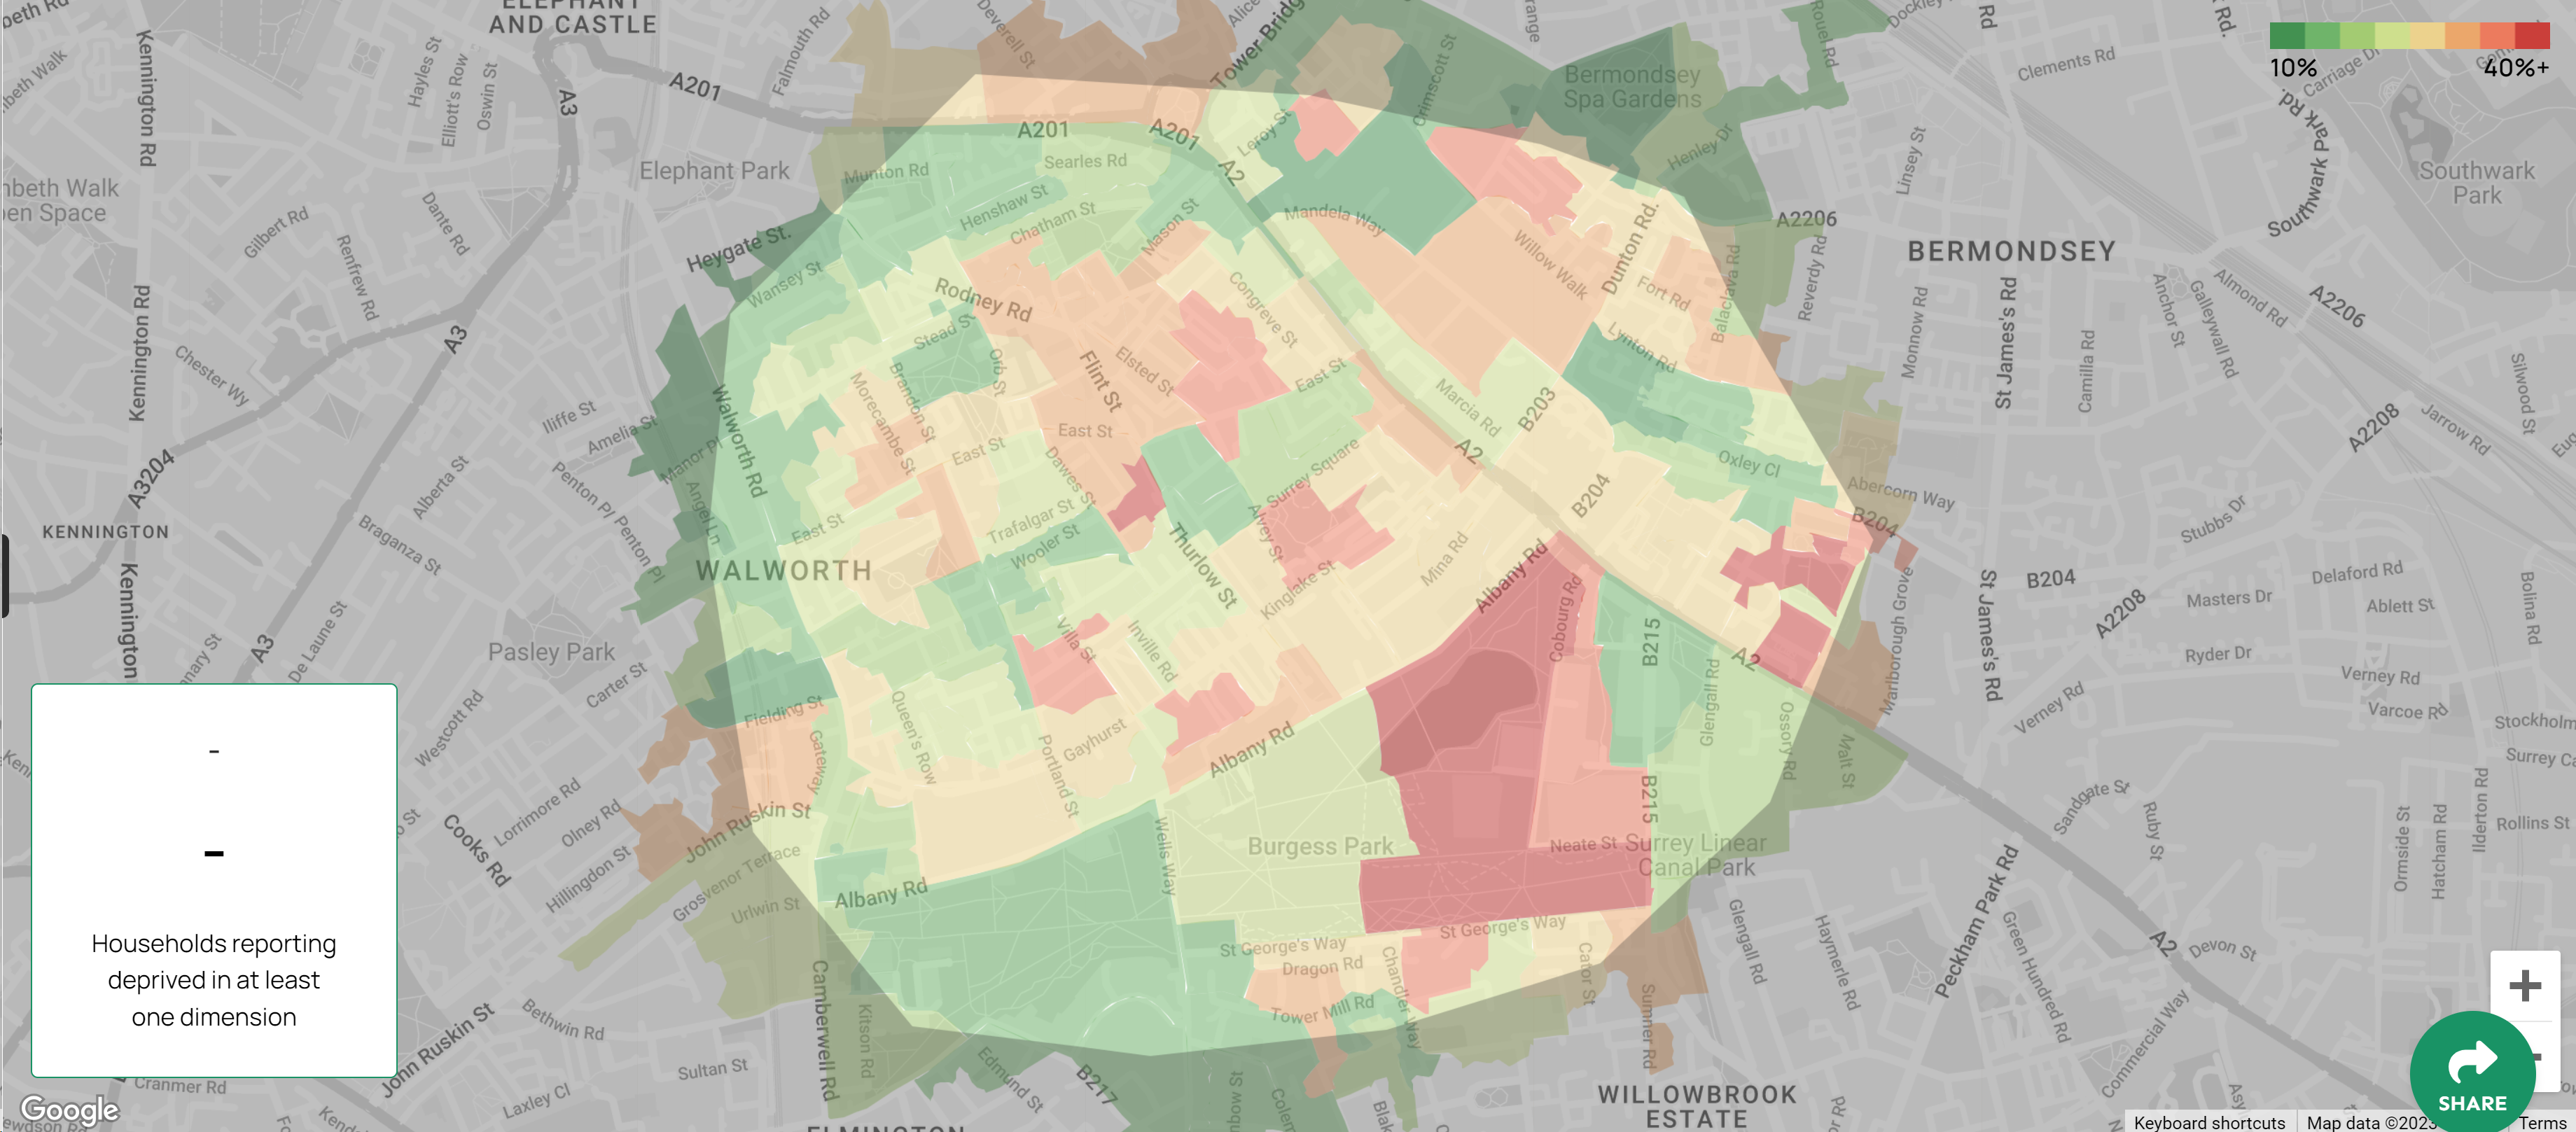

Source: PropertyData.co.uk

In [ ]:
# Load data
#Make sure you upload csv in 'Files' folder icon on the left handside
data = pd.read_csv('south_east_sample_prices_sold_prices.csv')
data.head(5)
print('Number of training examples: ', data.shape[0])

Number of training examples:  431


In [ ]:
# Convert 'Date' to datetime and extract year and month as new features
data['Date'] = pd.to_datetime(data['Date']) # Converting 'Date' column to datetime
data['Year'] = data['Date'].dt.year #Extracting year from 'Date'
data['Month'] = data['Date'].dt.month #Extracting month from 'Date'

# For 'Postcode', let's extract the area code which is the first part before the space
#E.g. SE15, SE16, SE17
data['Area_Code'] = data['Postcode'].apply(lambda x: x.split(' ')[0])

# Dropping the 'Date', 'Address', 'Postcode', and 'URL' columns as we won't use them in the model
data.drop(['Date', 'Address', 'Postcode', 'URL'], axis=1, inplace=True)

# One-hot encoding and feature preparation
#applies one hot encoding to feature columns that have categories i.e. represents the possible categories as unique columns with 1s or 0s
data = pd.get_dummies(data, drop_first=True)

#Separating our Features from what we are trying to predict (target variable)
X = data.drop(['Price paid'], axis=1)
#Our target variable
#prices are large values which will lead to errors between our predicted and actual values
#this can lead to a sensitive model to large values, so its better to use log which makes error distribution more uniform across data points
y = np.log(data['Price paid'])  # Log-transform the Price paid


# Display the first few rows to verify the changes
data.head()

#Area_Code_SE1, Type_Detached, Tenure_Freehold don't exist in the table because they are categories that exist implicitly when all other types or tenures are 0

,Bedrooms,Price paid,Lat,Lng,Year,Month,Type_Flat,Type_Semi-detached house,Type_Terraced house,New-build_Old stock,Tenure_Leasehold,Area_Code_SE15,Area_Code_SE16,Area_Code_SE17,Area_Code_SE5
0,1,365000,51.489845,-0.074342,2023,3,0,0,1,1,0,0,0,0,0
1,2,330000,51.485108,-0.091103,2023,3,1,0,0,1,1,0,0,1,0
2,2,365000,51.490397,-0.085105,2023,3,1,0,0,1,1,0,0,1,0
3,2,335000,51.488718,-0.094106,2023,2,1,0,0,1,1,0,0,1,0
4,3,355000,51.487997,-0.081331,2023,2,1,0,0,1,1,0,0,1,0


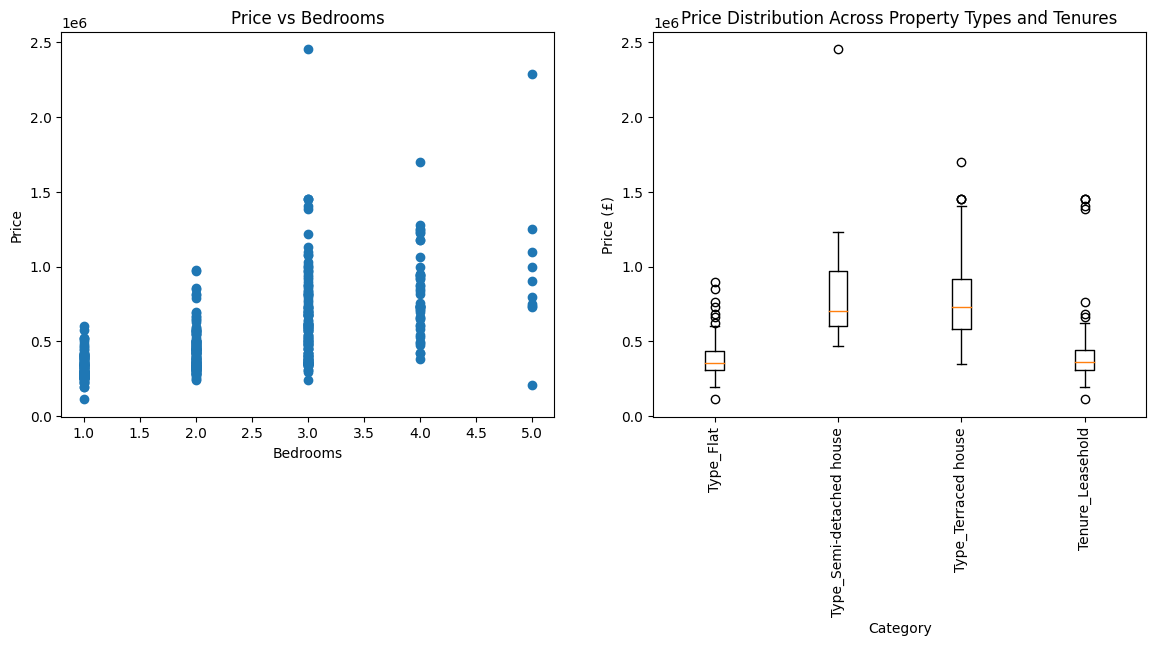

In [ ]:
# Visualize the features against the price
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Bedrooms vs Price
axs[0].scatter(data['Bedrooms'], np.exp(y))  # inverse log transform to original scale for visualization
axs[0].set_title('Price vs Bedrooms')
axs[0].set_xlabel('Bedrooms')
axs[0].set_ylabel('Price')

# One-hot encoded features vs Price
# Use box plots to show the distribution of prices for different property types and tenures
property_types = list(data.filter(regex='Type_').columns)
tenures = list(data.filter(regex='Tenure_').columns)

# Concatenate the property types and tenures for iteration
categories = property_types + tenures

for category in categories:
    # Create a boolean mask for each category
    mask = data[category] == 1
    # Apply the mask to the price and plot
    axs[1].boxplot(np.exp(y[mask]), positions=[categories.index(category)], labels=[category])

axs[1].set_title('Price Distribution Across Property Types and Tenures')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Price (£)')
axs[1].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

plt.show()

#Plot on the right shows some of our categorical variables (missing some categories like 'Type_Detached house' and 'Tenure_Freehold' )
#it shows we have quite a few outliers for price

In [ ]:
#Splitting data into training (60% of data) and test (40% of data) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state= 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(258, 14) (173, 14) (258,) (173,)


#Model Training

Overview:
- During the iterations of this project I found that my model was overfitting my data
- This was due to a small dataset i.e 431 examples
- So I needed to penalise it for learning too complex a model, so regularization has been introduced to help it generalise better.



#Cross-validation

**Typical Machine Learning work flow:**

In a typical machine learning workflow, a dataset might be split into a training, cross-validation, and test set in a 60-20-20 ratio. The cross-validation set is usually used for hyperparameter tuning, and the test set for evaluating the final model performance.


**K-Folds cross-validation:**

However, given our dataset's relatively small size (431 examples), we're employing K-Folds cross-validation, which is a more efficient method in such scenarios. Instead of setting aside a separate portion of the data for validation, we use our training data more effectively.

We allocate 60% of our data for training. This training data is then divided into K equal parts, with K set to 5 in this case. The model is trained on four of these parts, and the remaining fifth is used as a test set. This process is repeated in a sequence until each of the five parts has been used as the test set once.

By observing the effects of different hyperparameter settings on model performance across all five folds, we can determine the optimal set of hyperparameters for our model.

#ElasticNet

ElasticNet is a linear regression model that combines two types of regularization: L1 (lasso) and L2 (ridge).

It takes features to predict the target variable, whilst applying L1 and L2 penalties to avoid overfitting.

In [ ]:
# Cross-validation setup for ElasticNetCV(Combines L1 and L2 Regularization)
from sklearn.linear_model import ElasticNetCV
kf = KFold(n_splits=5, shuffle=True, random_state=42) #rand_state=42, as long we havethe same dataset and code each data point will be assigned to the exact same fold every time we run the code

'''After the polynomial features are created, they are fed into the ElasticNet model.
    ElasticNet works to find the best linear combination of these polynomial features to predict the target variable, while also applying both L1 and L2 penalties to keep the model simple and prevent overfitting.
    This step uses ElasticNetCV, which performs internal cross-validation (cv=5) to select the best hyperparameters, such as alpha and l1_ratio, for the Elastic Net model.
    It ensures reproducibility with a set random_state. The external KFold strategy can be used to evaluate the entire pipeline, including both the ElasticNet model and the preceding polynomial feature creation.
    Uses Coordinate Descent optimization algorithmn - Coordinate descent optimizes the loss function with respect to one coefficient at a time, keeping all others fixed. Useful when number of features are manageable and there is sparsity due to L1 loss.
    '''
model = Pipeline([
    #polynomial feature transformation
    ('poly', PolynomialFeatures(degree=3)), #for each feature adds polynomial combinations up to degree 3, allows model to derive more complex relationships between features and the target variable
     ('ELasticNet', ElasticNetCV(cv = 5, random_state = 42)) ])

# Train the model
model.fit(X_train, y_train) #executes defined sequence of steps: first, the polynomial feature transformation and then the fitting of the ElasticNet model.

# Evaluate it on the log-scale
#R², coefficient of determination is the default metric used due to regression estimator ElasticNetCV.
#Score of 1 if predictions perfectly fit data,
#Score of 0 means model is no better at predicting the target variable than a naive model that always predicts the mean of the target variable for all observations.
print("Train Set", model.score(X_train, y_train))
print("Test Set",model.score(X_test, y_test))

# Perform cross-validation
cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2') #across our 5 folds
cv_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print cross-validation R² and MSE scores
print("Cross-validated R² scores:", cv_r2_scores)
print("Cross-validated MSE scores:", -cv_mse_scores)


Train Set 0.6903700382968276
Test Set 0.6797992633007617
Cross-validated R² scores: [0.76787968 0.67855838 0.65833229 0.64150918 0.71847203]
Cross-validated MSE scores: [0.05321792 0.06257123 0.05173789 0.06957418 0.0660305 ]


#ElasticNet Performance Plotting

In [ ]:
# Fit the model on the entire dataset for final evaluation and plotting
#model is trained on the training dataset
model.fit(X_train, y_train) #model predicts across entire dataset (training + test)
y_pred = model.predict(X)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y)  # Inverse log transform

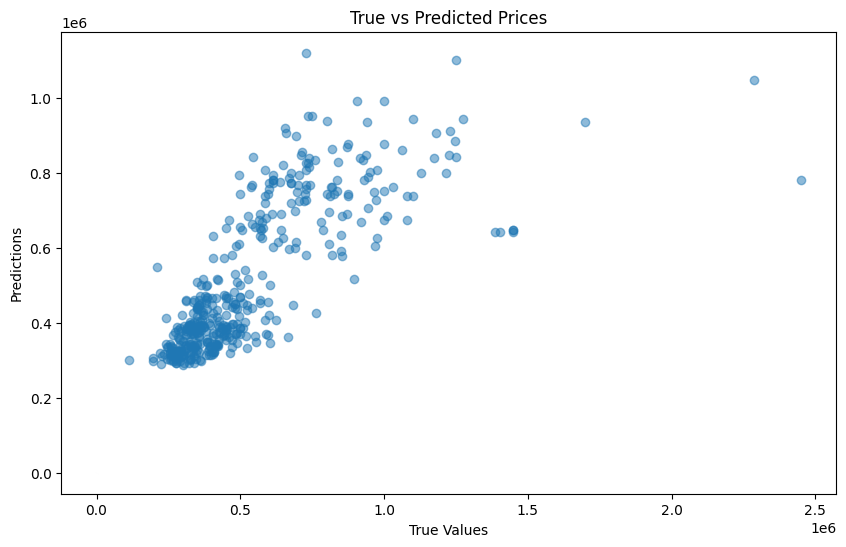

In [ ]:
# Plot Predicted vs True for the dataset
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Prices')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error
# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final R-squared: {final_r2}")
print(f"Final Mean Squared Error: {final_mse}")
print(f"Final Median Absolute Error: {final_mae}")


Final R-squared: 0.5740721287559618
Final Mean Squared Error: 0.06363772218146406
Final Median Absolute Error: 75140.37610859904


In [ ]:
# Determine the accuracy on the test set, Generalisation Error:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y_test)  # Inverse log transform

# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final Test R-squared: {final_r2}")
print(f"Final Test Mean Squared Error: {final_mse}")
print(f"Final Test Median Absolute Error: {final_mae}")

Final Test R-squared: 0.575289702443487
Final Test Mean Squared Error: 0.06838317999500473
Final Test Median Absolute Error: 76309.52914307936


#ExtraTreesRegressor

- Extremely Randomized Trees Regressor.
- Machine learning model that makes predictions based on the input data you give it.
- It's like a team of decision-making trees where each tree makes its own guess about what the output should be, and then all the trees vote to decide on the best answer.
- When building a standard decision tree, at every point where the tree decides to branch out (we call these points 'nodes'), it carefully chooses which feature of the data to use for making the split and what value of that feature should be the cutoff.
- ExtraTreesRegressor instead randomly picks a small group of features to consider. It doesn't necessarily pick the 'best' split in the way that a standard decision tree does.
- Builds a forest of trees that are all quite different from each other due to these random decisions. When it comes time to make a prediction, all of the individual trees in the forest give their vote, and the average of these votes is the final prediction given by the model.
- This randomness helps make the model more robust against overfitting

In [ ]:
# Cross-validation setup for ExtraTressRegressor:
from sklearn.ensemble import ExtraTreesRegressor
model_cv = Pipeline([
    ("poly", PolynomialFeatures(degree = 3)),
    ("ExtraTrees",ExtraTreesRegressor(n_estimators=100, random_state=42)) #100 trees in the forest
])

# Train the model
model_cv.fit(X_train,y_train)

# Evaluate it on the Log scale
print("Train Set", model_cv.score(X_train, y_train))
print("Test Set",model_cv.score(X_test, y_test))

# Perform cross-validation
cv_r2_scores = cross_val_score(model_cv, X, y, cv=kf, scoring='r2')
cv_mse_scores = cross_val_score(model_cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print cross-validation R² and MSE scores
print("Cross-validated R² scores:", cv_r2_scores)
print("Cross-validated MSE scores:", -cv_mse_scores)

Train Set 0.9998623045213186
Test Set 0.7828199711985051
Cross-validated R² scores: [0.81187005 0.72815025 0.70837642 0.65542523 0.71191827]
Cross-validated MSE scores: [0.04313231 0.05291777 0.04415983 0.06687342 0.06756764]


#ExtraTreesRegressor Performance Plotting

In [ ]:
# Fit the model on the entire dataset for final evaluation and plotting
#model is trained on the training dataset
model_cv.fit(X_train, y_train)
#model predicts across entire dataset (training + test)
y_pred = model_cv.predict(X)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y)  # Inverse log transform

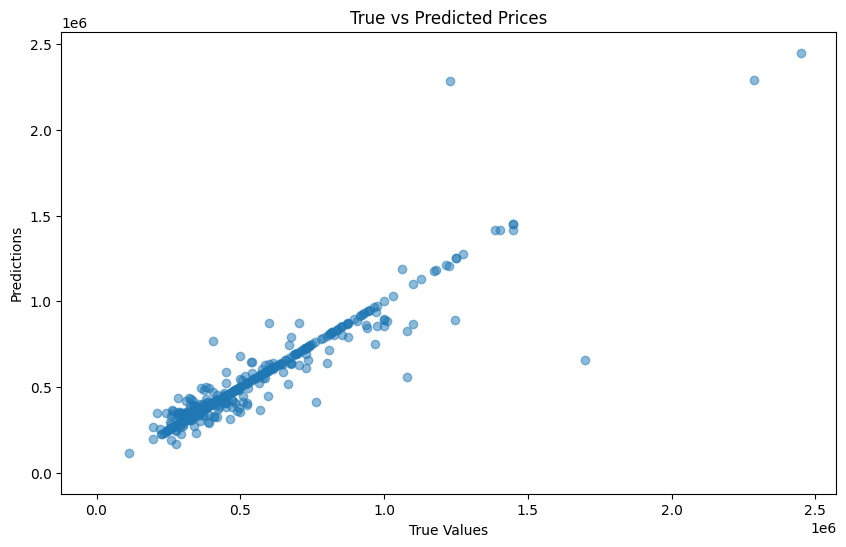

In [ ]:
# Plot Predicted vs True for the entire dataset
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Prices')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_log_error

# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final R-squared: {final_r2}")
print(f"Final Mean Squared Error: {final_mse}")
print(f"Final Median Absolute Error: {final_mae}")

Final R-squared: 0.8859522157125009
Final Mean Squared Error: 0.01863333815505439
Final Median Absolute Error: 1.3154931366443634e-08


In [ ]:
# Determine the accuracy on the test set, Generalisation Error:

y_pred = model_cv.predict(X_test)
y_pred = np.exp(y_pred)  # Inverse log transform
y_true = np.exp(y_test)  # Inverse log transform

# Final evaluation on the entire dataset
final_r2 = r2_score(y_true, y_pred)
final_mse = mean_squared_log_error(y_true, y_pred)
final_mae = median_absolute_error(y_true, y_pred)

print(f"Final Test R-squared: {final_r2}")
print(f"Final Test Mean Squared Error: {final_mse}")
print(f"Final Test Median Absolute Error: {final_mae}")

Final Test R-squared: 0.7230856378735382
Final Test Mean Squared Error: 0.04638168985488929
Final Test Median Absolute Error: 50365.547781640314
